## Polynomial curve fitting

In [2]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

In [3]:
# Generar datos sinusoidales
np.random.seed(42)
n_points = 100
x = np.linspace(0, 1, n_points)
y_true = np.sin(4 * np.pi * x)
noise = np.random.normal(0, 0.1, n_points)
y = y_true + noise

# Grado del polinomio
degree = 5

In [4]:
import numpy as np
from numpy.polynomial import chebyshev, legendre

# 1. Generar matriz de Vandermonde
A = np.vander(x, degree + 1, increasing=True)

# 2. Implementación de la matriz Φ (Chebyshev)
# Cada columna es un polinomio de Chebyshev T_k evaluado en x
Phi_cheb = np.zeros((len(x), degree + 1))
for k in range(degree + 1):
    Phi_cheb[:, k] = chebyshev.chebval(x, [0]*k + [1])

# 3. Implementación de la matriz Φ (Legendre)
# Cada columna es un polinomio de Legendre P_k evaluado en x
Phi_leg = np.zeros((len(x), degree + 1))
for k in range(degree + 1):
    Phi_leg[:, k] = legendre.legval(x, [0]*k + [1])


In [5]:
def chebyshev_design_matrix(x, degree):
    """
    Construye la matriz de diseño usando polinomios de Chebyshev (T_k).
    
    Parámetros
    ----------
    x : array (N,)
        Datos de entrada en [-1, 1]
    degree : int
        Grado máximo
    
    Retorna
    -------
    Phi : array (N, degree+1)
        Matriz de diseño
    """
    N = len(x)
    Phi = np.zeros((N, degree + 1))

    for k in range(degree + 1):

        if (k == 0):
            Phi[:, k] = 1
        elif (k == 1):
            Phi[:, k] == x
        else:
            Phi[:, k] == 2*x@Phi[:, k-1] - Phi[:, k-2]

    return Phi

In [6]:
def legendre_design_matrix(x, degree):
    """
    Construye la matriz de diseño usando polinomios de Legendre.
    
    Parámetros
    ----------
    x : array (N,)
        Datos de entrada en [-1, 1]
    degree : int
        Grado máximo del polinomio
    
    Retorna
    -------
    Phi : array (N, degree+1)
        Matriz de diseño
    """
    N = len(x)
    Phi = np.zeros((N, degree + 1))

    for k in range(degree + 1):
        # Coeficientes para P_k(x)
        if (k == 0):
            Phi[:, k] = 1
        elif (k == 1):
            Phi[:, k] == x
        else:
             Phi[:, k] = ((2*k + 1) * x * Phi[:, k-1] - (k - 1) * Phi[:, k-2]) / k + 1
    return Phi

In [7]:
# 1. Ajuste con CVXPY

# Crear la matriz de Vandermonde
A = np.vander(x, degree + 1, increasing=True)

# Definir la variable y resolver el problema de optimización
beta_cvx = cp.Variable(degree+1)
objective = cp.Minimize(cp.norm2(A@ beta_cvx - y)**2)
problem = cp.Problem(objective)
problem.solve()

coeff_cvx = beta_cvx.value

print(problem.value)
print(coeff_cvx)

5.844662420637483
[-4.71138800e-01  4.21080221e+01 -3.45718982e+02  9.71940994e+02
 -1.11351690e+03  4.46184837e+02]


In [8]:
# 2. Solución cerrada
coeff_closed = np.linalg.inv(A.T@A)@A.T@y
print(coeff_closed)

[-4.71138799e-01  4.21080221e+01 -3.45718982e+02  9.71940994e+02
 -1.11351690e+03  4.46184837e+02]


In [9]:
# 3. Usando numpy.polyfit
coeff_numpy = np.polyfit(x, y, degree)

# Comparar los resultados
print("Coeficientes obtenidos:")
print(f"CVXPY:       {coeff_cvx}")
print(f"Sol. Cerrada: {coeff_closed}")
print(f"Numpy:       {coeff_numpy}")

Coeficientes obtenidos:
CVXPY:       [-4.71138800e-01  4.21080221e+01 -3.45718982e+02  9.71940994e+02
 -1.11351690e+03  4.46184837e+02]
Sol. Cerrada: [-4.71138799e-01  4.21080221e+01 -3.45718982e+02  9.71940994e+02
 -1.11351690e+03  4.46184837e+02]
Numpy:       [ 4.46184837e+02 -1.11351690e+03  9.71940994e+02 -3.45718982e+02
  4.21080221e+01 -4.71138800e-01]


In [10]:
# Representar los resultados
x_fit = np.linspace(0, 1, 500)
y_fit_cvx = np.polyval(coeff_cvx[::-1], x_fit)
y_fit_closed = np.polyval(coeff_closed[::-1], x_fit)
y_fit_numpy = np.polyval(coeff_numpy[::-1], x_fit)

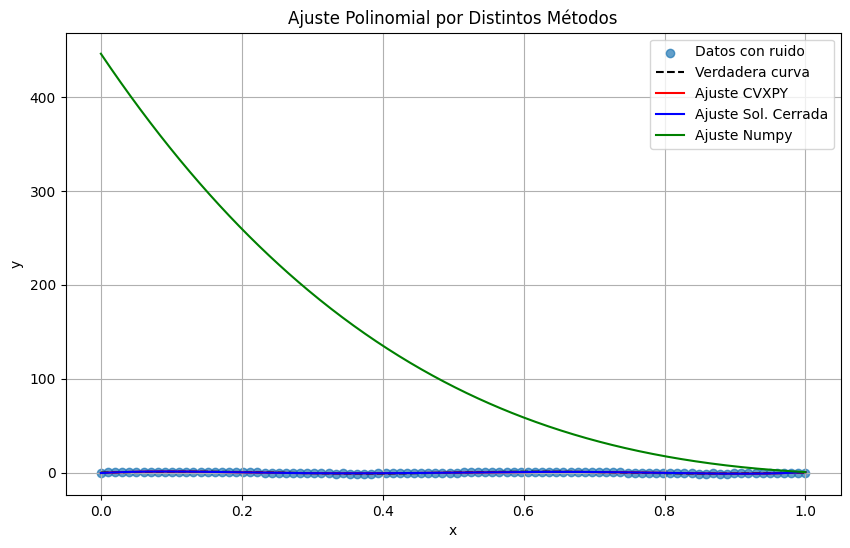

In [11]:
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label="Datos con ruido", alpha=0.7)
plt.plot(x, y_true, label="Verdadera curva", color="black", linestyle="--")
plt.plot(x_fit, y_fit_cvx, label="Ajuste CVXPY", color="red")
plt.plot(x_fit, y_fit_closed, label="Ajuste Sol. Cerrada", color="blue")
plt.plot(x_fit, y_fit_numpy, label="Ajuste Numpy", color="green")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Ajuste Polinomial por Distintos Métodos")
plt.grid()
plt.show()

In [ ]:
# Cálculo del error de estimación del polinomio con respecto al real

## Polynomial curve fitting con regularización

In [19]:
lambda_reg = 0.1

# 1. Ajuste con L2-norm (Ridge Regression) usando CVXPY
beta_L2 = cp.Variable(degree + 1)
objective_L2 = cp.Minimize(cp.norm2(A @ beta_L2 - y)**2 + lambda_reg * cp.norm2(beta_L2)**2)

problem_L2 = cp.Problem(objective_L2)
problem_L2.solve()

coeff_L2 = beta_L2.value

print(problem_L2.value)
print(coeff_L2)

41.69932995740821
[ 0.51026002 -2.06105318  1.97923329  1.11611624 -0.72157393 -1.69986476]


In [20]:
# 2. Ajuste con L1-norm (Lasso Regression) usando CVXPY
beta_L1 = cp.Variable(degree + 1)

# El objetivo es minimizar el error cuadrático + lambda * norma_L1 de los pesos
# cp.norm1(beta_L1) calcula la suma de los valores absolutos de los coeficientes
objective_L1 = cp.Minimize(cp.norm2(A @ beta_L1 - y)**2 + lambda_reg * cp.norm1(beta_L1))

# Crear y resolver el problema
problem_L1 = cp.Problem(objective_L1)
problem_L1.solve()

# Extraer los coeficientes óptimos
coeff_L1 = beta_L1.value

print("Valor óptimo de la función objetivo (Lasso):", problem_L1.value)
print("Coeficientes calculados con L1:\n", coeff_L1)

Valor óptimo de la función objetivo (Lasso): 39.680735692267575
Coeficientes calculados con L1:
 [ 8.63548901e-01 -5.61433880e+00  8.97392705e+00 -1.70001660e-07
 -5.28819231e+00  4.62906208e-08]


In [21]:
# Solución cerrada para Ridge

# 3. Solución cerrada para Ridge (Analytical Solution)
# Creamos una matriz identidad de tamaño (degree + 1)
I = np.eye(degree + 1)

# Aplicamos la fórmula: beta = inv(A.T @ A + lambda * I) @ A.T @ y
# Nota: np.linalg.solve es numéricamente más estable que np.linalg.inv
coeff_ridge_cerrada = np.linalg.solve(A.T @ A + lambda_reg * I, A.T @ y)

print("Coeficientes calculados con la solución cerrada:")
print(coeff_ridge_cerrada)

# Verificación de error entre CVXPY y la solución cerrada
print("\nDiferencia entre CVXPY y solución analítica:")
print(np.linalg.norm(coeff_L2 - coeff_ridge_cerrada))


Coeficientes calculados con la solución cerrada:
[ 0.51026032 -2.06105547  1.9792369   1.11611642 -0.72157679 -1.69986377]

Diferencia entre CVXPY y solución analítica:
5.246491877707479e-06


In [24]:
# 1. Predicción con el modelo ajustado
# Usamos las variables correctas (L2 y L1 con mayúsculas)
y_fit_l2 = np.polyval(coeff_L2[::-1], x_fit)
y_fit_l1 = np.polyval(coeff_L1[::-1], x_fit)

# Para la solución cerrada, usamos el nombre de la variable que definimos en numpy
y_fit_ridge_closef = np.polyval(coeff_ridge_cerrada[::-1], x_fit)

print(x.shape, y_fit_ridge_closef.shape)

(100,) (500,)


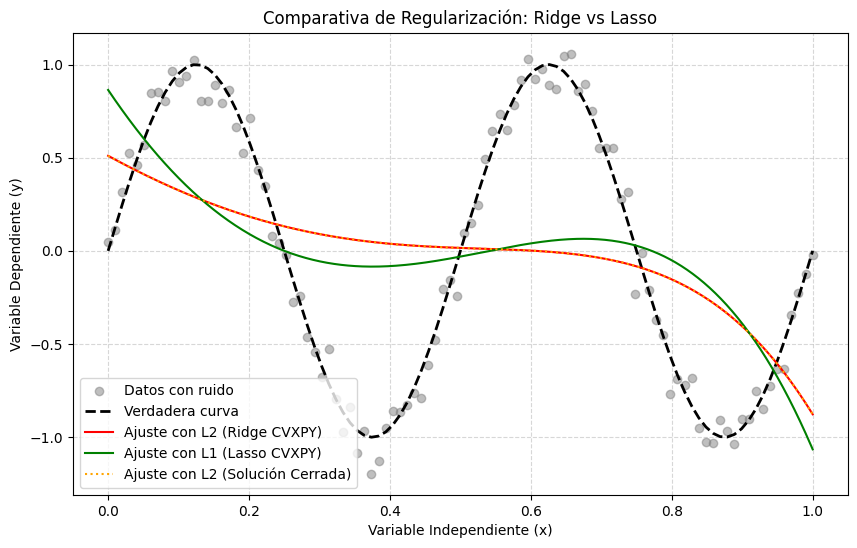

In [26]:
# Representación de resultados
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# 1. Datos originales y curva real
plt.scatter(x, y, label="Datos con ruido", alpha=0.5, color="gray")
plt.plot(x, y_true, label="Verdadera curva", color="black", linestyle="--", linewidth=2)

# 2. Curvas ajustadas (todas sobre x_fit para que sean comparables)
plt.plot(x_fit, y_fit_l2, label="Ajuste con L2 (Ridge CVXPY)", color="red", linewidth=1.5)
plt.plot(x_fit, y_fit_l1, label="Ajuste con L1 (Lasso CVXPY)", color="green", linewidth=1.5)

# Corregimos esta línea para que use x_fit en lugar de x
plt.plot(x_fit, y_fit_ridge_closef, label="Ajuste con L2 (Solución Cerrada)", color="orange", linestyle=":")

# Configuración de etiquetas y estilo
plt.legend()
plt.xlabel("Variable Independiente (x)")
plt.ylabel("Variable Dependiente (y)")
plt.title("Comparativa de Regularización: Ridge vs Lasso")
plt.grid(True, which='both', linestyle='--', alpha=0.5)

plt.show()

/home/jorgetg/Aprendizaje Automatico II/proyecto_Aprendizaje/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.346e-01, tolerance: 2.622e-03
  model = cd_fast.enet_coordinate_descent(


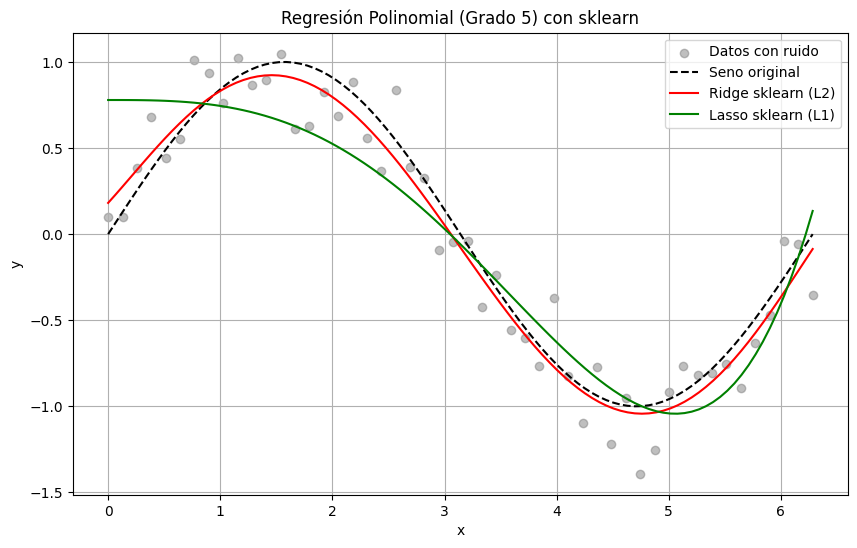

Coeficientes Ridge (sklearn): [ 0.          0.71944447  0.18357017 -0.31933611  0.07126887 -0.00448291]
Coeficientes Lasso (sklearn): [ 0.          0.          0.         -0.0349397  -0.00010093  0.0008353 ]


In [28]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso, Ridge
from sklearn.pipeline import make_pipeline
import numpy as np
import matplotlib.pyplot as plt

# 1. Generar datos sinusoidales
np.random.seed(42)
x = np.linspace(0, 2 * np.pi, 50).reshape(-1, 1)
y_true = np.sin(x).flatten()
y = y_true + np.random.normal(0, 0.2, len(x))

# 2. Grado del polinomio y parámetros
degree = 5
lambda_reg = 0.1

# 3. Modelos alternativos usando Pipelines de sklearn
# El Pipeline aplica primero la transformación polinómica y luego la regresión
model_ridge = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=lambda_reg))
model_lasso = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=lambda_reg))

# 4. Ajuste de los modelos
model_ridge.fit(x, y)
model_lasso.fit(x, y)

# 5. Predicciones para representar resultados
x_fit = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)
y_ridge_sk = model_ridge.predict(x_fit)
y_lasso_sk = model_lasso.predict(x_fit)

# 6. Representación gráfica
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='gray', alpha=0.5, label="Datos con ruido")
plt.plot(x_fit, np.sin(x_fit), 'k--', label="Seno original")
plt.plot(x_fit, y_ridge_sk, label=f"Ridge sklearn (L2)", color="red")
plt.plot(x_fit, y_lasso_sk, label=f"Lasso sklearn (L1)", color="green")

plt.title(f"Regresión Polinomial (Grado {degree}) con sklearn")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

# Imprimir los coeficientes obtenidos por sklearn
print("Coeficientes Ridge (sklearn):", model_ridge.named_steps['ridge'].coef_)
print("Coeficientes Lasso (sklearn):", model_lasso.named_steps['lasso'].coef_)

Columnas detectadas en el archivo: ['Temperature', 'Sales']
Usando 'Temperature' como entrada (X) y 'Sales' como salida (y)


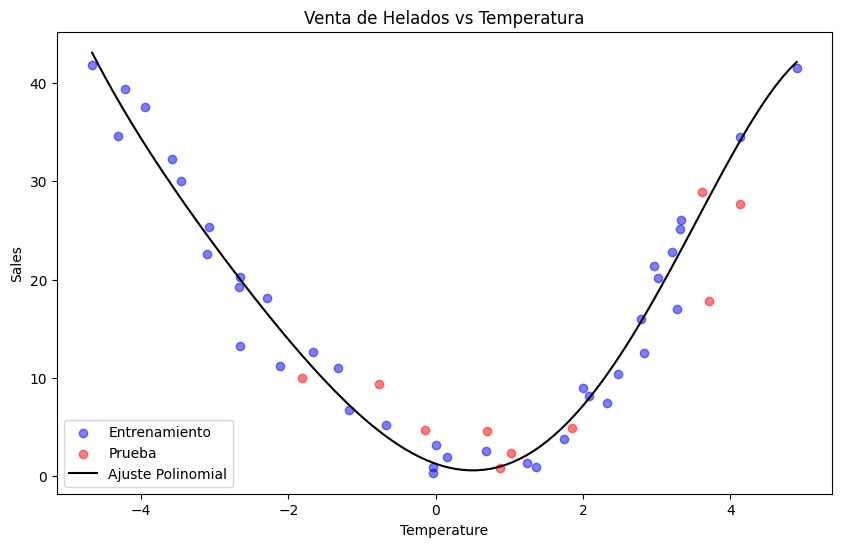

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

# --- CONFIGURACIÓN ---
lambda_reg = 0.1
degree = 5

# 1. Cargamos los datos
file_path = "icecream/Ice_cream_selling_data.csv"  
data = pd.read_csv(file_path)

# Imprimimos los nombres reales de las columnas para que los veas
print("Columnas detectadas en el archivo:", data.columns.tolist())

# --- DETECCIÓN AUTOMÁTICA DE COLUMNAS ---
# Buscamos la columna que contenga algo de 'Temp' y la que contenga 'Profits' o 'Sales'
col_x = [c for c in data.columns if 'Temp' in c][0]
col_y = [c for c in data.columns if 'Profit' in c or 'Sales' in c or 'Revenue' in c][0]

print(f"Usando '{col_x}' como entrada (X) y '{col_y}' como salida (y)")

X = data[[col_x]].values
y = data[col_y].values

# 2. Dividimos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Transformación Polinómica
poly = PolynomialFeatures(degree=degree)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# 4. Ajuste del modelo Ridge
modelo_ridge = Ridge(alpha=lambda_reg)
modelo_ridge.fit(X_train_poly, y_train)

# 5. Visualización
x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_pred_plot = modelo_ridge.predict(poly.transform(x_range))

plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='blue', label='Entrenamiento', alpha=0.5)
plt.scatter(X_test, y_test, color='red', label='Prueba', alpha=0.5)
plt.plot(x_range, y_pred_plot, color='black', label='Ajuste Polinomial')
plt.xlabel(col_x)
plt.ylabel(col_y)
plt.title('Venta de Helados vs Temperatura')
plt.legend()
plt.show()

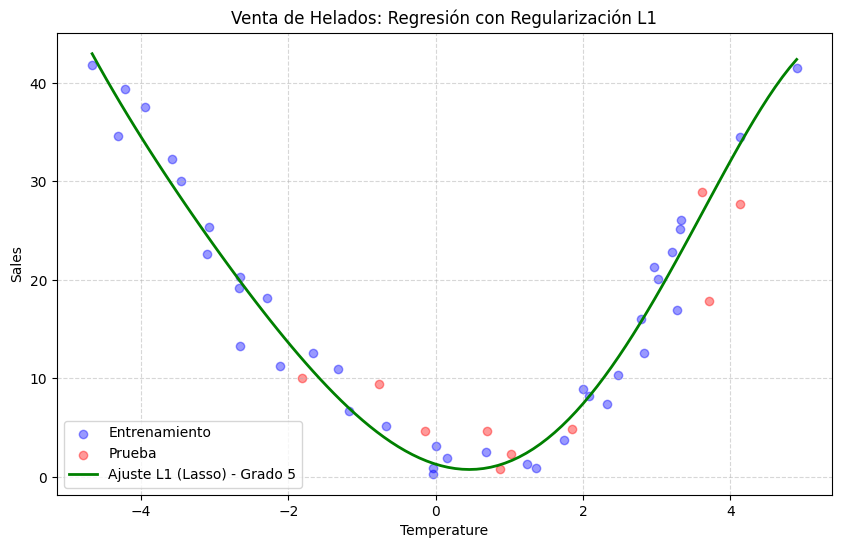

Precisión R^2 (Lasso) en Test: 0.7892

Coeficientes obtenidos con L1 (Lasso):
Grado 0: 0.000000
Grado 1: -2.327551
Grado 2: 2.413388
Grado 3: 0.218089
Grado 4: -0.025812
Grado 5: -0.005744


In [31]:
# Solución considerando regularización L1

# --- 1. Ajuste con L1-norm (Lasso Regression) ---
# Usamos el mismo lambda_reg y los datos ya transformados (X_train_poly)

modelo_lasso = Lasso(alpha=lambda_reg, max_iter=10000)
modelo_lasso.fit(X_train_poly, y_train)

# --- 2. Predicciones para la representación ---
# Usamos el mismo x_range de antes para que la curva sea comparable
y_pred_lasso = modelo_lasso.predict(poly.transform(x_range))

# --- 3. Visualización de resultados ---
plt.figure(figsize=(10, 6))

# Puntos de datos
plt.scatter(X_train, y_train, color='blue', label='Entrenamiento', alpha=0.4)
plt.scatter(X_test, y_test, color='red', label='Prueba', alpha=0.4)

# Curva Lasso
plt.plot(x_range, y_pred_lasso, color='green', linewidth=2, label=f'Ajuste L1 (Lasso) - Grado {degree}')

plt.xlabel(col_x)
plt.ylabel(col_y)
plt.title('Venta de Helados: Regresión con Regularización L1')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# --- 4. Análisis de Coeficientes ---
print(f"Precisión R^2 (Lasso) en Test: {modelo_lasso.score(X_test_poly, y_test):.4f}")
print("\nCoeficientes obtenidos con L1 (Lasso):")
# Mostramos cómo Lasso ha "limpiado" el modelo
for i, coef in enumerate(modelo_lasso.coef_):
    print(f"Grado {i}: {coef:.6f}")


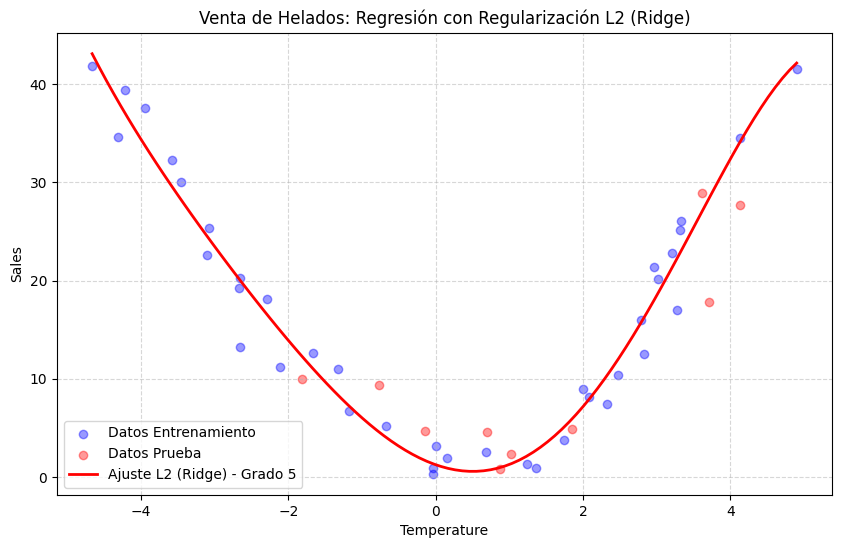

Precisión R^2 (Ridge) en Test: 0.7788

Coeficientes obtenidos con L2 (Ridge):
Grado 0: 0.000000
Grado 1: -2.633162
Grado 2: 2.428660
Grado 3: 0.266111
Grado 4: -0.026201
Grado 5: -0.007327


In [32]:
# Solución considerando regularización L2


# --- 1. Ajuste con L2-norm (Ridge Regression) ---
# Utilizamos el parámetro lambda_reg (alpha en sklearn) definido anteriormente

modelo_ridge = Ridge(alpha=lambda_reg)
modelo_ridge.fit(X_train_poly, y_train)

# --- 2. Predicciones para la representación ---
# Evaluamos el modelo en el rango de temperaturas para dibujar la curva
y_pred_ridge = modelo_ridge.predict(poly.transform(x_range))

# --- 3. Visualización de resultados ---
plt.figure(figsize=(10, 6))

# Puntos de entrenamiento y prueba
plt.scatter(X_train, y_train, color='blue', label='Datos Entrenamiento', alpha=0.4)
plt.scatter(X_test, y_test, color='red', label='Datos Prueba', alpha=0.4)

# Curva Ridge (L2)
plt.plot(x_range, y_pred_ridge, color='red', linewidth=2, label=f'Ajuste L2 (Ridge) - Grado {degree}')

plt.xlabel(col_x)
plt.ylabel(col_y)
plt.title('Venta de Helados: Regresión con Regularización L2 (Ridge)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# --- 4. Evaluación y Coeficientes ---
print(f"Precisión R^2 (Ridge) en Test: {modelo_ridge.score(X_test_poly, y_test):.4f}")
print("\nCoeficientes obtenidos con L2 (Ridge):")
for i, coef in enumerate(modelo_ridge.coef_):
    print(f"Grado {i}: {coef:.6f}")

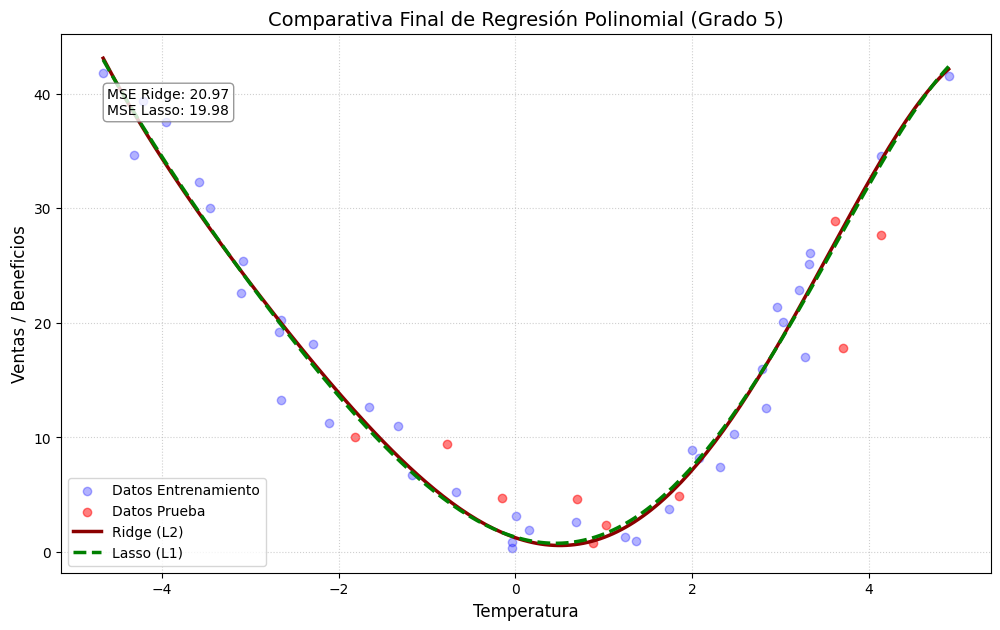

In [35]:
import matplotlib.pyplot as plt

# 1. Definir rango para la curva suave
x_plot = np.linspace(X.min(), X.max(), 200).reshape(-1, 1)
x_plot_poly = poly.transform(x_plot)

# 2. Obtener predicciones de todos los modelos
y_plot_ridge = modelo_ridge.predict(x_plot_poly)
y_plot_lasso = modelo_lasso.predict(x_plot_poly)

# 3. Representación de la nueva gráfica comparativa
plt.figure(figsize=(12, 7))

# Datos reales
plt.scatter(X_train, y_train, color='blue', alpha=0.3, label='Datos Entrenamiento')
plt.scatter(X_test, y_test, color='red', alpha=0.5, label='Datos Prueba')

# Curvas de los modelos
plt.plot(x_plot, y_plot_ridge, color='darkred', linewidth=2.5, label='Ridge (L2)')
plt.plot(x_plot, y_plot_lasso, color='green', linewidth=2.5, linestyle='--', label='Lasso (L1)')

# Configuración estética
plt.title('Comparativa Final de Regresión Polinomial (Grado 5)', fontsize=14)
plt.xlabel('Temperatura', fontsize=12)
plt.ylabel('Ventas / Beneficios', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)

# Anotación de métricas (opcional)
mse_ridge = mean_squared_error(y_test, modelo_ridge.predict(X_test_poly))
mse_lasso = mean_squared_error(y_test, modelo_lasso.predict(X_test_poly))

plt.annotate(f'MSE Ridge: {mse_ridge:.2f}\nMSE Lasso: {mse_lasso:.2f}', 
             xy=(0.05, 0.85), xycoords='axes fraction', 
             bbox=dict(boxstyle="round", fc="white", ec="gray", alpha=0.8))

plt.show()

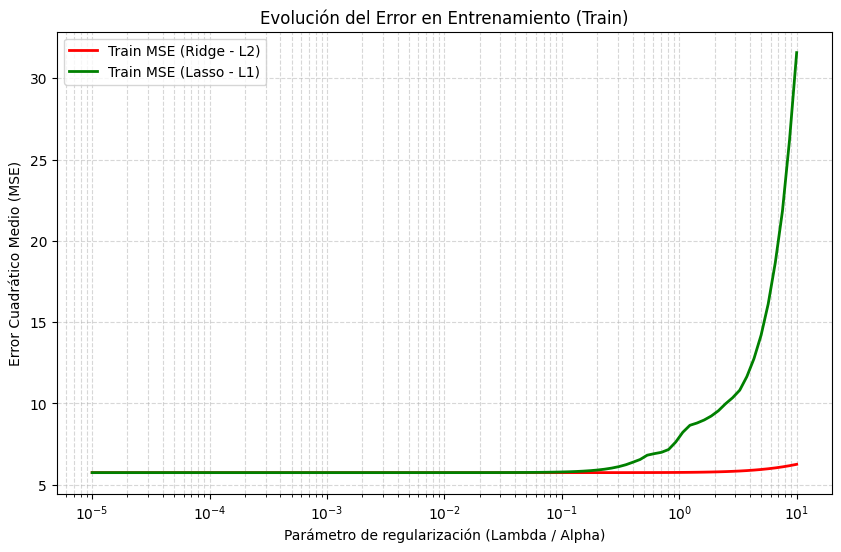

MSE mínimo en Train (Ridge): 5.7492
MSE mínimo en Train (Lasso): 5.7492


In [33]:
# Evolución del error en train

from sklearn.metrics import mean_squared_error

# 1. Definimos un rango de valores para lambda (alpha) en escala logarítmica
alphas = np.logspace(-5, 1, 100)
train_mse_ridge = []
train_mse_lasso = []

for a in alphas:
    # Evolución Ridge
    m_ridge = Ridge(alpha=a)
    m_ridge.fit(X_train_poly, y_train)
    p_ridge = m_ridge.predict(X_train_poly)
    train_mse_ridge.append(mean_squared_error(y_train, p_ridge))
    
    # Evolución Lasso
    m_lasso = Lasso(alpha=a, max_iter=10000)
    m_lasso.fit(X_train_poly, y_train)
    p_lasso = m_lasso.predict(X_train_poly)
    train_mse_lasso.append(mean_squared_error(y_train, p_lasso))

# 2. Representación gráfica de la evolución del error
plt.figure(figsize=(10, 6))
plt.plot(alphas, train_mse_ridge, label='Train MSE (Ridge - L2)', color='red', linewidth=2)
plt.plot(alphas, train_mse_lasso, label='Train MSE (Lasso - L1)', color='green', linewidth=2)

plt.xscale('log') # Usamos escala logarítmica para el eje X para ver mejor el rango
plt.xlabel('Parámetro de regularización (Lambda / Alpha)')
plt.ylabel('Error Cuadrático Medio (MSE)')
plt.title('Evolución del Error en Entrenamiento (Train)')
plt.legend()
plt.grid(True, which="both", linestyle='--', alpha=0.5)
plt.show()

# 3. Conclusión breve
print(f"MSE mínimo en Train (Ridge): {min(train_mse_ridge):.4f}")
print(f"MSE mínimo en Train (Lasso): {min(train_mse_lasso):.4f}")


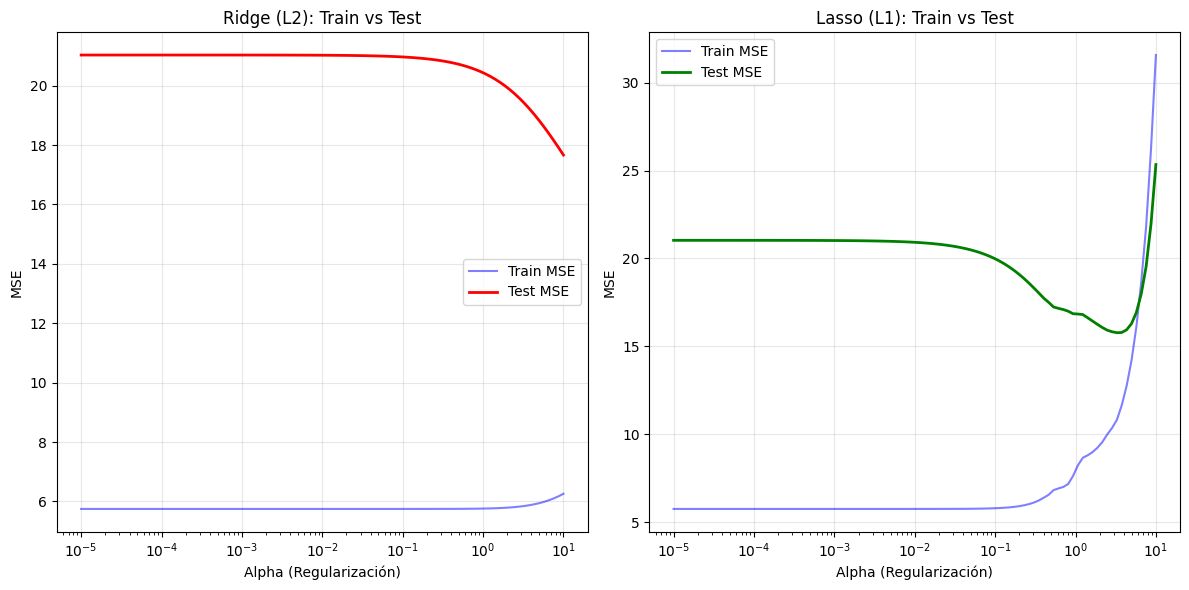

Alpha óptimo para Ridge: 10.000000 (MSE mínimo: 17.6652)
Alpha óptimo para Lasso: 3.274549 (MSE mínimo: 15.7738)


In [34]:
# Evolución del error en test

# 1. Listas para almacenar los errores de test
test_mse_ridge = []
test_mse_lasso = []

for a in alphas:
    # Evaluación Ridge en Test
    m_ridge = Ridge(alpha=a)
    m_ridge.fit(X_train_poly, y_train)
    p_ridge_test = m_ridge.predict(X_test_poly)
    test_mse_ridge.append(mean_squared_error(y_test, p_ridge_test))
    
    # Evaluación Lasso en Test
    m_lasso = Lasso(alpha=a, max_iter=10000)
    m_lasso.fit(X_train_poly, y_train)
    p_lasso_test = m_lasso.predict(X_test_poly)
    test_mse_lasso.append(mean_squared_error(y_test, p_lasso_test))

# 2. Representación gráfica comparativa (Train vs Test)
plt.figure(figsize=(12, 6))

# Subplot para Ridge
plt.subplot(1, 2, 1)
plt.plot(alphas, train_mse_ridge, label='Train MSE', color='blue', alpha=0.5)
plt.plot(alphas, test_mse_ridge, label='Test MSE', color='red', linewidth=2)
plt.xscale('log')
plt.xlabel('Alpha (Regularización)')
plt.ylabel('MSE')
plt.title('Ridge (L2): Train vs Test')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot para Lasso
plt.subplot(1, 2, 2)
plt.plot(alphas, train_mse_lasso, label='Train MSE', color='blue', alpha=0.5)
plt.plot(alphas, test_mse_lasso, label='Test MSE', color='green', linewidth=2)
plt.xscale('log')
plt.xlabel('Alpha (Regularización)')
plt.ylabel('MSE')
plt.title('Lasso (L1): Train vs Test')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Identificación del Alpha Óptimo
alpha_opt_ridge = alphas[np.argmin(test_mse_ridge)]
alpha_opt_lasso = alphas[np.argmin(test_mse_lasso)]

print(f"Alpha óptimo para Ridge: {alpha_opt_ridge:.6f} (MSE mínimo: {min(test_mse_ridge):.4f})")
print(f"Alpha óptimo para Lasso: {alpha_opt_lasso:.6f} (MSE mínimo: {min(test_mse_lasso):.4f})")
